# Description:

This employee retention tool kit is for predecting whether or not given employee leave the company, if yes then HR department can take respective actions to retain the employee.

It is a classification problem

# Dataset:

Dataset is avaialable on Kaggle:
https://www.kaggle.com/gummulasrikanth/hr-employee-retention

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
import pickle

%matplotlib inline

In [2]:
dataset_location = r"dataset/employee.csv"
data = pd.read_csv(dataset_location)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
print(data.columns.values)

['satisfaction_level' 'last_evaluation' 'number_project'
 'average_montly_hours' 'time_spend_company' 'Work_accident' 'left'
 'promotion_last_5years' 'sales' 'salary']


### Column Description:

Each record represents data for an employee

1. satisfaction_level: It represents work satisfaction level of employee
2. last_evaluation: Employee performance in last appraisal cycle
3. number_project: Number of projects that employee worked for
4. average_montly_hours: Average monthly hours spent by employee at work
5. time_spend_company: It is a tenure in years for which an employee worked so far in the company 
6. Work_accident: Number of accidents happened at work by an employee
7. left: Is that individual is still an employee or not
8. promotion_last_5years: Number of promotions in last 5 years for the employee
9. sales: It actually represents the department of the employee
10. salary: Salary of an employee

In [4]:
print("Number of rows and columns in the dataset are {} and {} respectively".format(data.shape[0], data.shape[1]))

Number of rows and columns in the dataset are 14999 and 10 respectively


We will replace Sales column by department as it will be easy to interpret

In [5]:
data.rename(columns={'sales': 'department'}, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [7]:
data[data.isnull()].count()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

### Observations:

1. Number of columns: 10
2. Number of rows: 14999
3. Number of numeric column: 8
4. Number of categorical column: 2
5. No null values spoted in dataset

# Exploratory Data Analysis

In [8]:
# Target variable
data.groupby('left')['left'].count()

left
0    11428
1     3571
Name: left, dtype: int64

[Text(0, 0.5, 'Percent')]

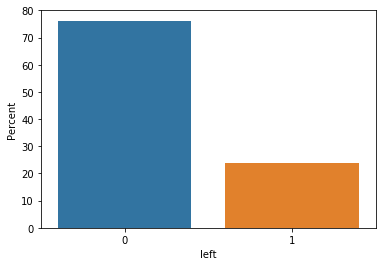

In [9]:
ax = sns.barplot(x="left", y="left", data=data, estimator=lambda x: len(x) / len(data['left']) * 100)
ax.set(ylabel="Percent")

### Observations:

1. From the dataset of 14999 points we have 24% of records with the employee leaving the company
2. Thus the given dataset is not balanced
3. We have to take into consideration sampling while designing clasification model

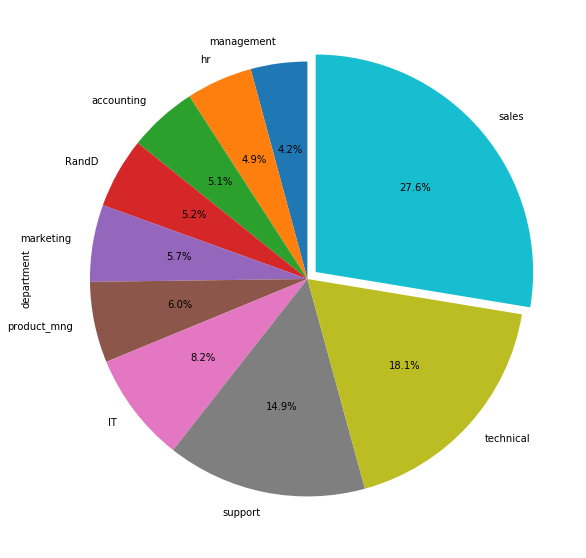

In [10]:
data.groupby('department')['department'].count().sort_values(ascending=True).plot.pie(figsize=(10,10),
                                                                 explode=(0,0,0,0,0,0,0,0,0,0.05),
                                                                 startangle=90,
                                                                 autopct='%1.1f%%')

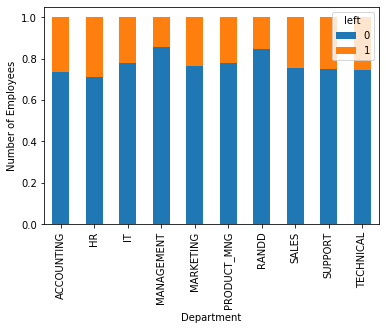

In [11]:
x = pd.crosstab(index = data.department.str.upper(), columns = data.left, normalize='index')

x.plot.bar(stacked=True)
plt.legend(title='left')
plt.xlabel("Department")
plt.ylabel("Number of Employees")
plt.rcParams["figure.figsize"] = (10,3)
plt.show()

### Observations:

1. There are total of 10 noticeable department in the company
2. Most of the employee ~28% are in Sales department
3. Even though there are wide range of employees over different departments, % of employees leaving the company is almost same
4. We may say that department of the employee is not significant feature in the employee retention analysis, however we will still consider it as of now and can explore more in the feature engineering

In [12]:
columns = ['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company']

data[columns].describe()

,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company
count,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,201.050337,3.498233
std,0.248631,0.171169,49.943099,1.460136
min,0.090000,0.360000,96.000000,2.000000
25%,0.440000,0.560000,156.000000,3.000000
50%,0.640000,0.720000,200.000000,3.000000
75%,0.820000,0.870000,245.000000,4.000000
max,1.000000,1.000000,310.000000,10.000000


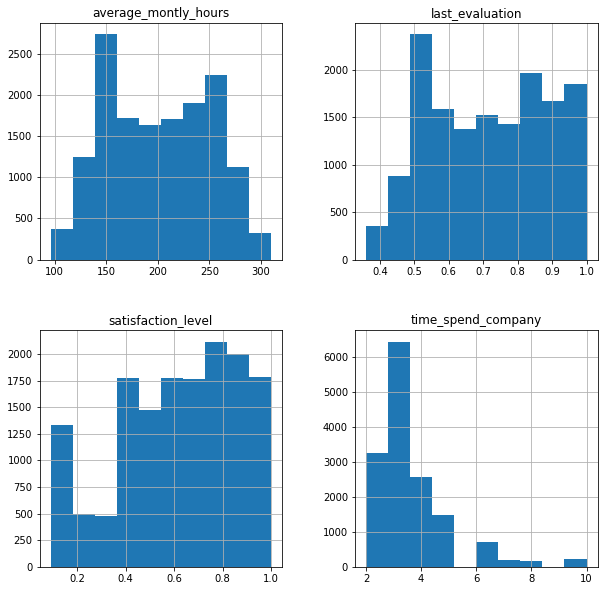

In [13]:
histograms = data[columns].hist(figsize=(10, 10), bins=10)

### Observations:

1. Most of the employees are with 4 years and less experienced at the comapany
2. Even though official business hours per month is 160, the average hours spent by an employee is 200 hrs/month
3. Around 75% of employees are not satisfied with the work at company (< 0.8)
4. Almost 50% of employees did not performed well in the last apparaisal cycle

In [14]:
# Binary variable analysis:

columns = ['Work_accident', 'promotion_last_5years', 'salary']

summary = pd.concat([pd.crosstab(data[x], data['left']) for x in columns], keys=columns)
summary['%_left'] = summary[1] * 100 /(summary[0] + summary[1])

summary

left                              0     1     %_left
Work_accident         0        9428  3402  26.515978
                      1        2000   169   7.791609
promotion_last_5years 0       11128  3552  24.196185
                      1         300    19   5.956113
salary                high     1155    82   6.628941
                      low      5144  2172  29.688354
                      medium   5129  1317  20.431275

### Observations:

1. Employees with no work accident tends to leave the company, it is due to the fact market attracts good talent
2. Non-promoted employees are not happy as they are not appreciated for their work and thus leaves the company
3. Most of the employees with low-mid salary range are not satisfied for the compensation they are reciving and tends to leave the company for better opportunities

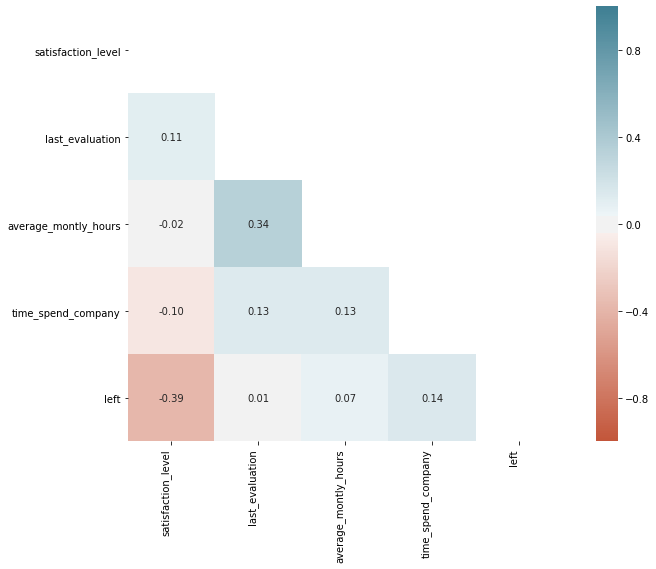

In [15]:
#Continouse variable analysis:

columns = ['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company', 'left']
corr = data[columns].corr()
fig, ax = plt.subplots(figsize = (12,8))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200, as_cmap=True),
    square=True,
    mask=mask,
    annot=True,
    fmt=".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation='vertical',
    horizontalalignment='right'
);

### Observation

1. Most of the satisfied employees are continue to serve the company as they might enjoy the work culture
2. Employees with good performance in last appraisal cycle are likely to leave the comapny
3. Also, employee worked for more time per month and who are senior in the comapy are likely to leave the company
4. Junior employee are more satisfied with the work and they spend less number of hours per month

In [16]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [17]:
# Converting categorical features into numeric

categorical_variables = ['department', 'salary']

data_new = pd.get_dummies(data, columns=categorical_variables, drop_first=True)
data_new.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [18]:
# At this stage we will consider all the departments for the model building and evaluate the result with feature importance

print("Total number of features are {} ".format(data_new.shape[1] -1 ))

Total number of features are 18 


### Observation:

1. feature scale is not standard, which may add baise in the model
2. We will thus perform feature scalling to get all the feature in the same range

In [19]:
def trainTestSplit(data, target):
    
    X = data.drop([target],axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    return (X_train, X_test, y_train, y_test)

In [20]:
def normalizeInput(X_train, X_test):
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    return (X_train, X_test)

In [21]:
def randomSampling(X_train, y_train, target):
    return (X_train, y_train)

In [22]:
def upSampling(X_train, y_train, target, match_max = 100):
    
    if match_max > 100 or match_max < 0:
        match_max = 100
    
    data = pd.concat([X_train, y_train], axis=1)
    classes = data.groupby(target)[target].size()
    max_value = classes.max()
    max_class = classes.idxmax()
    upData = []
    for item in classes.index:
        if item != max_class:
            temp = data[data[target]==item]
            A = resample(temp,
                          replace=True, # sample with replacement
                          n_samples=int(max_value * match_max / 100), # match number in majority class
                          random_state=20) # reproducible results
            upData.append(A)
    B = data[data[target]==max_class]
    upData.append(B)
    
    data = pd.concat(upData)
    
    X_train = data.drop([target],axis=1)
    y_train = data[target]
    return (X_train, y_train)

In [23]:
def downSampling(X_train, y_train, target, match_max = 100):
    if match_max > 100 or match_max < 0:
        match_max = 100
    
    data = pd.concat([X_train, y_train], axis=1)
    classes = data.groupby(target)[target].size()
    min_value = classes.max()
    min_class = classes.idxmax()
    downData = []
    for item in classes.index:
        if item != min_class:
            temp = data[data[target]==item]
            A = resample(temp,
                          replace=True, # sample with replacement
                          n_samples=int(min_value * match_max / 100), # match number in majority class
                          random_state=20) # reproducible results
            downData.append(A)
    B = data[data[target]==min_class]
    downData.append(B)
    
    data = pd.concat(downData)
    
    X_train = data.drop([target],axis=1)
    y_train = data[target]
    
    return (X_train, y_train)

In [24]:
def SMOTESampling(X_train, y_train, target):
    
    sm = SMOTE(random_state = 2) 
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    
    return (X_train_res, y_train_res)

In [25]:
def trainModels(data, target, configuration):
    if(data.empty or not target or not configuration):
        print("Please provide setup parameters!")
    else:
        target = configuration['target']
        TestModels = []
        file = open('Execution_Summary.txt', 'w')
        file1 = open('Accuracy Summary.txt', 'w')
        X_train_o, X_test_o, y_train_o, y_test_o = trainTestSplit(data, target)
        for normalize in configuration['normalize']:
            for sampling in configuration['sampling']:
                for model_name in configuration['model']:
                    print("{}, {}, {}".format(normalize, sampling, model_name))
                    if sampling == 'random':
                        X_train, y_train = randomSampling(X_train_o, y_train_o, target)
                    elif sampling == "up":
                        X_train, y_train = upSampling(X_train_o, y_train_o, target)
                    elif sampling == "down":
                        X_train, y_train = downSampling(X_train_o, y_train_o, target)
                    elif sampling == "SMOTE":
                        X_train, y_train = SMOTESampling(X_train_o, y_train_o, target)
                    if normalize:
                        X_train, X_test = normalizeInput(X_train, X_test_o)
                    if model_name == "randomForest":
                        model = RandomForestClassifier()
                        model.fit(X_train, y_train)
                    elif model_name == "LogisticRegression":
                        model = LogisticRegression()
                        model.fit(X_train, y_train)
                    elif model_name == "DecisionTreeClassifier":
                        model = DecisionTreeClassifier(max_depth=8)
                        model.fit(X_train, y_train)
                    elif model_name == "GaussianNB":
                        model = GaussianNB()
                        model.fit(X_train, y_train)
                    elif model_name == "MLPClassifier":
                        model = MLPClassifier(hidden_layer_sizes=(30,50,50))
                        model.fit(X_train, y_train)
                    
                    filename = str(normalize)+"_"+str(sampling)+"_"+str(model_name)+".sav"
                    
                    pickle.dump(model, open(filename, 'wb'))
                    
                    TestModels.append(filename)

                    file.write(filename)
                    file.write("\n")

                    predictions = model.predict(X_test)
                    predictions_trn = model.predict(X_train)

                    accuracy_train = accuracy_score(y_train, predictions_trn)

                    cm = confusion_matrix(y_train, predictions_trn)
                    
                    file.write("Training Consfusion Metrics:")
                    file.write("\n")
                    file.write(str(cm))
                    file.write("\n")

                    accuracy_test = accuracy_score(y_test_o, predictions)
                    
                    cm = confusion_matrix(y_test_o, predictions)
                    data = filename +","+ str(accuracy_train) +","+ str(accuracy_test)
                    file1.write(data) 
                    file1.write("\n")

                    file.write("Testing Consfusion Metrics:")
                    file.write("\n")
                    file.write(str(cm))
                    file.write("\n")

    file.close()
    file1.close()
    return TestModels

In [26]:
configuration = {
                    'sampling': ['up', 'down', 'SMOTE'],
                    'model': ['randomForest', 'LogisticRegression', 'DecisionTreeClassifier', 'GaussianNB', 'MLPClassifier'],
                    'normalize': [True, False],
                    'target': "left"
                }

In [27]:
start = time.time()

target = "left"
test_models = trainModels(data_new, target, configuration)

end = time.time()

print("Time for execution: {} secs!".format(end-start))

True, up, randomForest
True, up, LogisticRegression
True, up, DecisionTreeClassifier
True, up, GaussianNB
True, up, MLPClassifier
True, down, randomForest
True, down, LogisticRegression
True, down, DecisionTreeClassifier
True, down, GaussianNB
True, down, MLPClassifier
True, SMOTE, randomForest
True, SMOTE, LogisticRegression
True, SMOTE, DecisionTreeClassifier
True, SMOTE, GaussianNB
True, SMOTE, MLPClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


False, up, randomForest
False, up, LogisticRegression
False, up, DecisionTreeClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



False, up, GaussianNB
False, up, MLPClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


False, down, randomForest
False, down, LogisticRegression
False, down, DecisionTreeClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



False, down, GaussianNB
False, down, MLPClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


False, SMOTE, randomForest
False, SMOTE, LogisticRegression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


False, SMOTE, DecisionTreeClassifier
False, SMOTE, GaussianNB
False, SMOTE, MLPClassifier
Time for execution: 148.5823106765747 secs!


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [28]:
acc = pd.read_csv('Accuracy Summary.txt', header=None)

In [29]:
acc.head()

,0,1,2
0,True_up_randomForest.sav,1.000000,0.991000
1,True_up_LogisticRegression.sav,0.770838,0.759667
2,True_up_DecisionTreeClassifier.sav,0.972052,0.974000
3,True_up_GaussianNB.sav,0.689893,0.593000
4,True_up_MLPClassifier.sav,0.997156,0.974667


In [30]:
acc[2].max()

0.991

In [31]:
data_2 = data_new[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'salary_low', 'salary_medium']]